# Gemma

In [1]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained("google/gemma-2b-it", dtype="float16")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2b-it into HookedTransformer


## Embeddings

The model has the following embedding features:

In [2]:
for name, param in model.named_parameters():
    if "embed" in name:
        print(name, param.shape)

embed.W_E torch.Size([256000, 2048])
unembed.W_U torch.Size([2048, 256000])
unembed.b_U torch.Size([256000])


### Dataset

Using words in English with Japanese and Spanish translations, I intend to see if there exists information in the embedding that would indicate which language one was speaking in.

In [2]:
from src import datasets
import importlib

importlib.reload(datasets)

# Load Data
eng_jpn_words = datasets.loadMyWordPairs("japanese")
eng_spn_words = datasets.loadMyWordPairs("spanish")

# Convert words to tokens
eng_jpn_tokens = eng_jpn_words.copy()
eng_jpn_tokens["lang1"] = eng_jpn_words["lang1"].apply(lambda x: model.to_tokens(x, prepend_bos=False)[0])
eng_jpn_tokens["lang2"] = eng_jpn_words["lang2"].apply(lambda x: model.to_tokens(x, prepend_bos=False)[0])

eng_spn_tokens = eng_spn_words.copy()
eng_spn_tokens["lang1"] = eng_spn_words["lang1"].apply(lambda x: model.to_tokens(x, prepend_bos=False)[0])
eng_spn_tokens["lang2"] = eng_spn_words["lang2"].apply(lambda x: model.to_tokens(x, prepend_bos=False)[0])

# Eliminate rows with multiple tokens
def eliminate_multiple_tokens(my_words):
    bad_rows = []
    for i in range(len(my_words)):
        eng_token = my_words.iloc[i]["lang1"]
        sec_token = my_words.iloc[i]["lang2"]

        if eng_token.shape[0] > 1 or sec_token.shape[0] > 1:
            bad_rows.append(i)

    return bad_rows

eng_jpn_tokens = eng_jpn_tokens.drop(eliminate_multiple_tokens(eng_jpn_tokens)).reset_index(drop=True)
eng_spn_tokens = eng_spn_tokens.drop(eliminate_multiple_tokens(eng_spn_tokens)).reset_index(drop=True)

print("Japanese words: ", len(eng_jpn_tokens))
print("Spanish words: ", len(eng_spn_tokens))

Japanese words:  117
Spanish words:  159


### PCA on Difference

Taking the PCA on the difference between the English tokens and the target language tokens, I intend on using PCA to identify 2-axis that best describe the transition between English and another language.

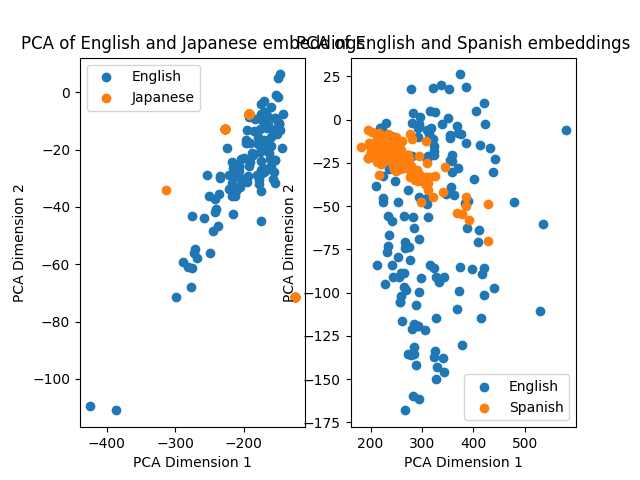

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
from src import embeddingCompare

importlib.reload(embeddingCompare)

fig = plt.figure()
ax_jpn = fig.add_subplot(121)
ax_spn = fig.add_subplot(122)

ax_jpn.set_title("Japanese")
ax_spn.set_title("Spanish")

eng_jpn_pca = embeddingCompare.plot_embedding_pca(ax_jpn, model, eng_jpn_tokens['lang1'], eng_jpn_tokens['lang2'], 2, "English", "Japanese")
eng_spn_pca = embeddingCompare.plot_embedding_pca(ax_spn, model, eng_spn_tokens['lang1'], eng_spn_tokens['lang2'], 2, "English", "Spanish")
plt.show()

### Compare Direct Axis

Since there appears to be major clustering with the target language compared to the English words, the next step was to identify the axis that were in charge of this behavior.

In [ ]:
importlib.reload(embeddingCompare)
jpn_dir, jpn_std = embeddingCompare.compute_average_embedding_direction(model, eng_jpn_tokens['lang1'], eng_jpn_tokens['lang2'])
spn_dir, spn_std = embeddingCompare.compute_average_embedding_direction(model, eng_spn_tokens['lang1'], eng_spn_tokens['lang2'])

print(jpn_dir.shape, jpn_std.shape)

print('\nJapanese Mapping')
embeddingCompare.print_embedding_compare(jpn_dir, jpn_std, 10)
print('\nSpanish Mapping')
embeddingCompare.print_embedding_compare(spn_dir, spn_std, 10)

(2048,) (2048,)
Highest mean values:
Index: 1699, Mean: 15.7734375, Std: 10.125
Index: 478, Mean: 7.828125, Std: 5.59765625
Index: 2034, Mean: 7.7265625, Std: 6.5234375
Index: 1577, Mean: 7.27734375, Std: 3.484375
Index: 1976, Mean: 5.96875, Std: 2.30859375
Index: 1896, Mean: 5.47265625, Std: 4.08984375
Index: 1068, Mean: 5.38671875, Std: 3.294921875
Index: 803, Mean: 5.3828125, Std: 2.33984375
Index: 1214, Mean: 5.32421875, Std: 2.958984375
Index: 1127, Mean: 5.18359375, Std: 2.873046875
Highest mean values:
Index: 1699, Mean: 18.890625, Std: 13.3203125
Index: 1967, Mean: 15.4765625, Std: 10.875
Index: 1553, Mean: 8.953125, Std: 7.890625
Index: 1380, Mean: 8.5, Std: 5.53125
Index: 924, Mean: 7.60546875, Std: 4.9140625
Index: 2034, Mean: 7.2109375, Std: 6.5234375
Index: 1645, Mean: 7.10546875, Std: 5.65625
Index: 1097, Mean: 6.37109375, Std: 4.8515625
Index: 1535, Mean: 6.25390625, Std: 6.06640625
Index: 1577, Mean: 6.109375, Std: 5.3515625


Of note, for both Spanish and Japanese, the primary axis that moved the text from English to the target language is axis 1699, with both additionally have corresponding axis of 2034 and 1577 in there top 10. Unfortunately, the uncertainty in these axis are large. Meaning it is difficult to make conclusion statements regarding the results.